In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex6 import *

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection1/dataset/Train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection1/dataset/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_main = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 187 files belonging to 2 classes.
Found 66 files belonging to 2 classes.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

#getting the pre-trained base
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.20),
    
    # Base
    pretrained_base,
    
    # Head
    layers.GlobalMaxPool2D(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [3]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    ds_main,
    batch_size = 128,
    validation_data=ds_valid,
    epochs=35,
    callbacks=[early_stopping],
)

Epoch 1/35
3/3 [==============================] - 14s 2s/step - loss: 1.0680 - binary_accuracy: 0.3797 - val_loss: 0.9302 - val_binary_accuracy: 0.4394
Epoch 2/35
3/3 [==============================] - 5s 2s/step - loss: 0.8250 - binary_accuracy: 0.4171 - val_loss: 0.7699 - val_binary_accuracy: 0.3636
Epoch 3/35
3/3 [==============================] - 3s 625ms/step - loss: 0.6859 - binary_accuracy: 0.5455 - val_loss: 0.7057 - val_binary_accuracy: 0.5000
Epoch 4/35
3/3 [==============================] - 3s 1s/step - loss: 0.6376 - binary_accuracy: 0.6364 - val_loss: 0.6957 - val_binary_accuracy: 0.5758
Epoch 5/35
3/3 [==============================] - 2s 804ms/step - loss: 0.6315 - binary_accuracy: 0.6257 - val_loss: 0.6976 - val_binary_accuracy: 0.5758
Epoch 6/35
3/3 [==============================] - 3s 1s/step - loss: 0.6301 - binary_accuracy: 0.6471 - val_loss: 0.6994 - val_binary_accuracy: 0.5606
Epoch 7/35
3/3 [==============================] - 2s 800ms/step - loss: 0.6324 - binary

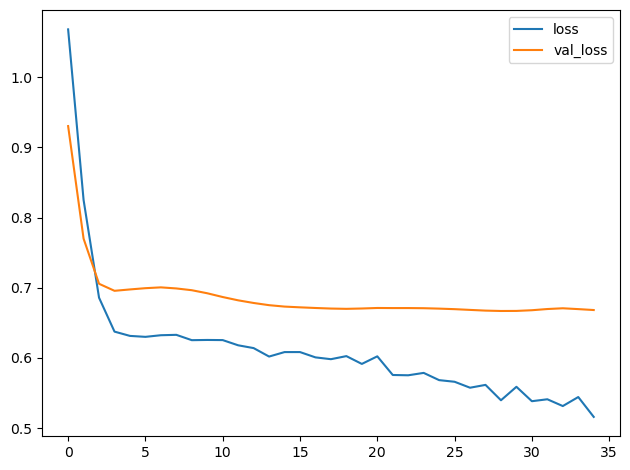

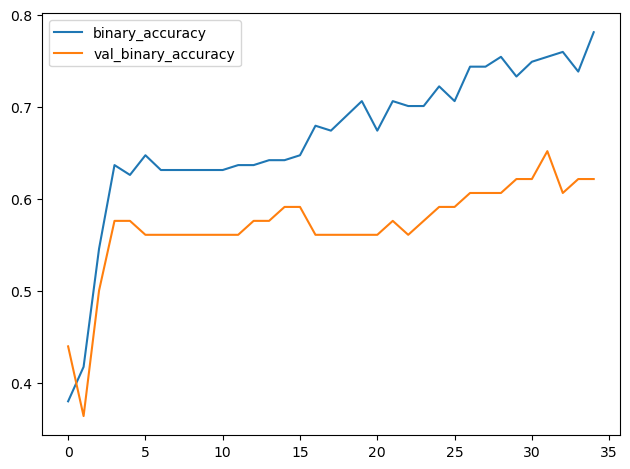

In [4]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();